# Feature Extraction

### 1. Feature Extraction
**Model to identify causal relationships**: 
feature extraction network (ResNet18) trained on ImageNet and 
classifier network (two 512-unit hidden layers) trained on Pascal VOC 2012

In [1]:
import json
import numpy as np
import torch
from torch import nn
from torchvision.models import resnet18

In [2]:
def feature_extractor():
    model_ft = resnet18(pretrained=True)
    # finetune
    for param in model_ft.parameters():
        param.requires_grad = False
    # modify classifier
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Flatten()
    # features = model_ft._modules.get('avgpool')
    return model_ft

In [3]:
class Classifier(nn.Module):
    def __init__(self, in_features=512, hidden_dim=512):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(in_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 20)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        # softmax
        return x

In [4]:
device = 'cpu'

resnet = feature_extractor().to(device)
classifier = Classifier().to(device)

img = torch.rand(size=[1,3,224,224])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\yeong/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [6]:
resnet.eval()

features = resnet(img)
print(features.shape)
object_logodds = classifier(features)
print(object_logodds.shape)

torch.Size([1, 512])
torch.Size([1, 20])


### 2. ResNet Classifier Training

**Dataset**: 
subset of 99,309 MSCOCO images belonging to 20 Pascal object categories. 
resize (224x224, 짧은 쪽이 224 pixel로 rescale하고 224x224 centercrop).

In [1]:
import json
import numpy as np
import pylab
import matplotlib.pyplot as plt
import skimage.io as io
from PIL import Image
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

c:\USERS\YEONG\MINICONDA3\ENVS\NCC\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# object categories in pascal voc
categories = [
    'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
    'dining table', 'dog', 'horse', 'motorcycle', 'person', 'potted plant', 'sheep', 'couch', 'train', 'tv'
]
# 16 matched categories in coco dataset
# no matched in coco: aeroplane, motorbike, sofa, television
# aeroplane - airplane, motorbike - motorcycle, sofa - couch, television - tv

In [4]:
dataDir = 'data/coco'
dataType='train2014'
# dataType='val2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
# coco_cats=[cat['name'] for cat in cats]
coco_cats = {cat['id']: cat['name'] for cat in cats}
# print('COCO categories: \n{}\n'.format(', '.join(coco_cats)))

# coco_cats_sup = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(', '.join(coco_cats_sup)))

loading annotations into memory...
Done (t=9.99s)
creating index...
index created!


In [5]:
# get all images containing given categories, select one at random
idx = 0
dataset = []
for cat in categories:
    catIds = coco.getCatIds(catNms=cat)
    imgIds = coco.getImgIds(catIds=catIds)
    print(f'{cat}: {len(imgIds)}')
    for imgId in imgIds:
        annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        label = {'imgId': imgId, 'categories': [], 'bbox': []}
        for i, ann in enumerate(anns):
            label['categories'].append(coco_cats[ann['category_id']])
            label['bbox'].append(ann['bbox'])
        
        img_file_name = coco.loadImgs(imgId)[0]['file_name']
        label['file_name'] = img_file_name
        
        # dataset[idx] = label
        dataset.append(label)
        idx += 1
len(dataset)

airplane: 2243
bicycle: 2287
bird: 2241
boat: 2098
bottle: 5968
bus: 2791
car: 8606
cat: 2818
chair: 8950
cow: 1389
dining table: 8378
dog: 3041
horse: 2068
motorcycle: 2442
person: 45174
potted plant: 3084
sheep: 1105
couch: 3170
train: 2464
tv: 3191


113508

In [6]:
with open('data/coco/trainIds.txt', 'w') as f:
    json.dump(dataset, f, indent=4)

ValueError: shape mismatch: value array of shape (426,426,640,3) could not be broadcast to indexing result of shape (426,426,640)

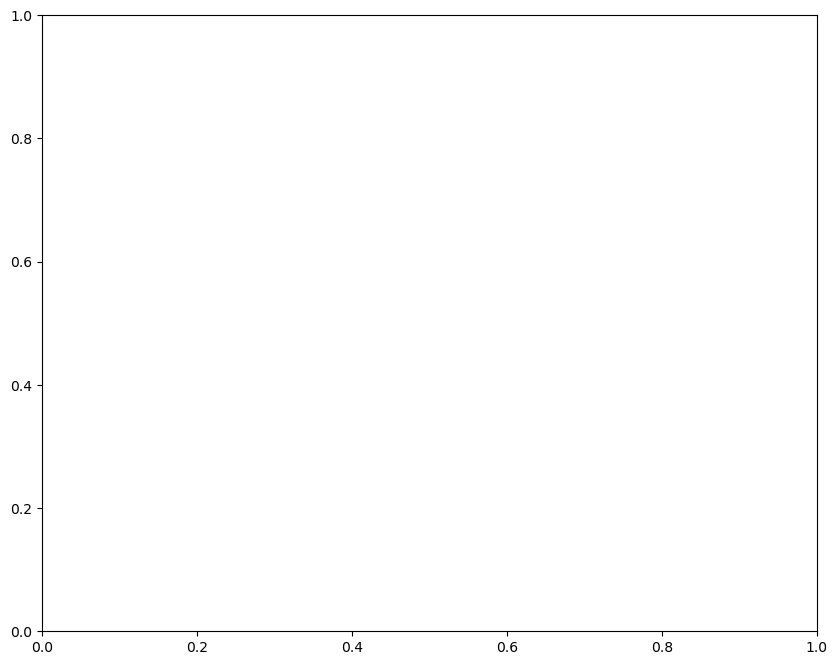

In [20]:
# load and display instance annotations
fig, ax = plt.subplots(figsize=(10, 8))
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img = coco.loadImgs(221184)[0]
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
# ax.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=coco.getCatIds(catNms=categories[0]), iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
masks = np.zeros((img['height'],img['width']))
for i, ann in enumerate(anns):
    masks[coco.annToMask(ann)==1] = 1
    # ax.text(anns[i]['bbox'][0], anns[i]['bbox'][1], coco_cats[anns[i]['category_id']], style='italic', 
    #         bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
masks = masks.astype(np.int8)
# I[:,masks] = 0

ax.imshow(I); plt.axis('off')

In [7]:
# MSCOCO image (bbox + label)
class COCODataset(Dataset):
    def __init__(self, dataDir='data/coco', transform=None):
        # dataDir = dataDir
        dataType='train2014'
        # annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
        self.img_path = f'{dataDir}/{dataType}/'

        # initialize COCO api for instance annotations
        # self.coco=COCO(annFile)

        # json
        with open('data/coco/trainIds.txt', 'r') as f:
            self.dataset = json.load(f) # 'img_id', 'bbox', 'anns'
        
        # transform
        self.transform = transform

    def __getitem__(self, index):
        data = self.dataset[index]
        # img = Image.open(self.img_path+data['file_name'])
        object_img = read_image(self.img_path+data['file_name'])
        context_img = read_image(self.img_path+data['file_name'])
        
        cats = torch.tensor([categories.index(x) for x in data['categories']])
        
        # img = draw_bounding_boxes(img, bboxs)
        for bbox in data['bbox']:
            x1, x2 = int(bbox[1]), int(bbox[1]+bbox[3])+1
            y1, y2 = int(bbox[0]), int(bbox[0]+bbox[2])+1
            context_img[:, x1:x2, y1:y2] = 0
            object_img[:, ]
                
        if self.transform is not None:
            img = self.transform(img)

        img = T.ToPILImage()(img)
        
        # object image
        
        # context image
        
        
        return img, cats, bboxs
    
    def __len__(self):
        return len(self.dataset)

In [8]:
transform = T.Compose([
    # you can add other transformations in this list
    # T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])
dataset = COCODataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=1)

In [11]:
idx = 0
for data in dataloader:
    # print(data[0].shape)
    # print()
    # print(data[1].shape)
    # print()
    # print(data[2].shape)
    # print()
    idx+=1
    if idx == 2:
        break

UnboundLocalError: local variable 'img' referenced before assignment

In [2]:
img_path = f'data/coco/train2014/'
with open('data/coco/trainIds.txt', 'r') as f:
    dataset = json.load(f) # 'img_id', 'bbox', 'anns'
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor()
])

torch.Size([3, 426, 640])
[7.51, 27.18, 632.49, 376.64]
[1.73, 244.57, 215.63, 62.28]


C:\Users\yeong\AppData\Local\Temp\ipykernel_18748\3749093695.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask>0, dtype=torch.uint8)


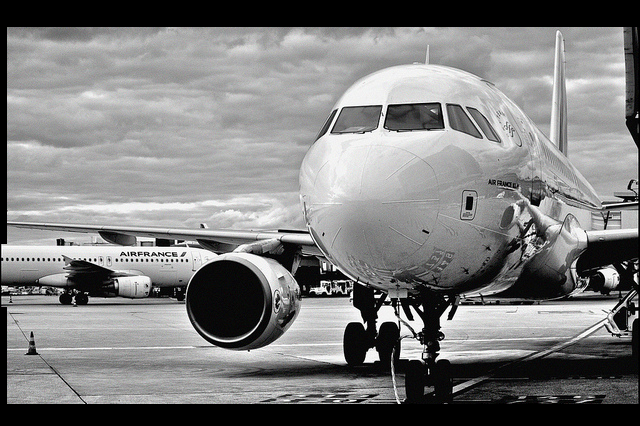

In [19]:
data = dataset[0]

img = read_image(img_path+data['file_name'])
print(img.shape)
# bboxs = torch.tensor(data['bbox'])
# print(bboxs[1])

# bboxs = torch.tensor([[bbox[0],bbox[1],bbox[2]+bbox[0],bbox[3]+bbox[1]] for bbox in bboxs])

mask = torch.zeros(img.shape[1:], dtype=int)
for bbox in data['bbox']:
    print(bbox)
    x1, x2 = int(bbox[1]), int(bbox[1]+bbox[3])+1
    y1, y2 = int(bbox[0]), int(bbox[0]+bbox[2])+1
    mask[x1:x2,y1:y2] = 1
    mask = torch.tensor(mask>0, dtype=torch.uint8)
    objectImg = torch.where(mask1>0,img,mask1)
    contextImg = torch.where(mask1>0,mask,img)
        
# img
# # img = draw_bounding_boxes(img, bboxs)
objectImg = T.ToPILImage()(objectImg)
contextImg = T.ToPILImage()(contextImg)
objectImg

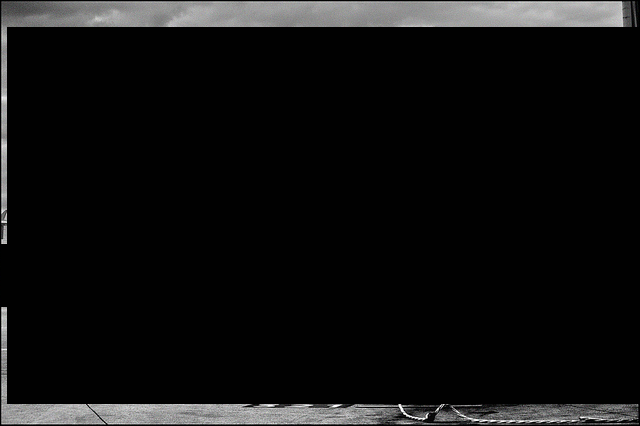

In [20]:
contextImg

In [9]:
type(img)

torch.Tensor

C:\Users\yeong\AppData\Local\Temp\ipykernel_18748\3041912524.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask1 = torch.tensor(mask>0, dtype=torch.uint8)


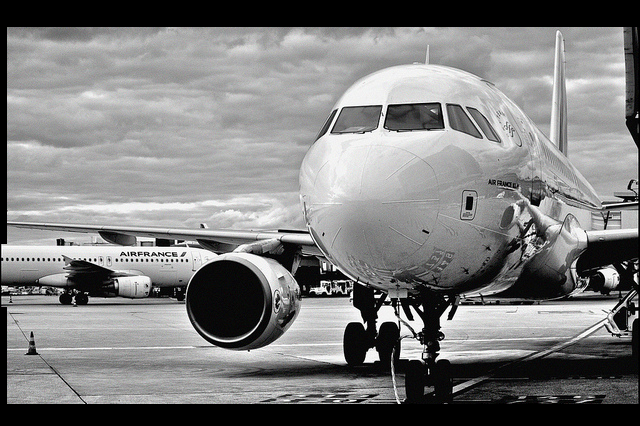

In [13]:
mask1 = torch.tensor(mask>0, dtype=torch.uint8)
img1 = torch.where(mask1>0,img,mask1)
T.ToPILImage()(img1)

C:\Users\yeong\AppData\Local\Temp\ipykernel_18748\250542156.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask1 = torch.tensor(mask>0, dtype=torch.uint8)


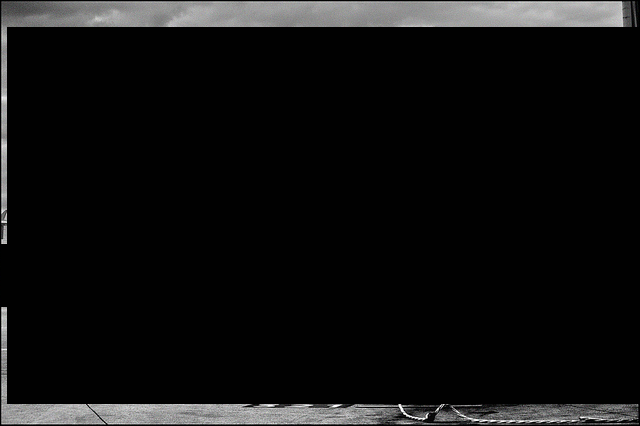

In [15]:
mask1 = torch.tensor(mask>0, dtype=torch.uint8)
img1 = torch.where(mask1>0,mask1,img)
T.ToPILImage()(img1)